# Deep Hedging AI
### Recurrent Network: impact of using recurrent networks on hedging forward started options

Hans Buehler, January 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-01-24 07:23:45.985504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 07:23:46.125377: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-24 07:23:47.722059: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-24 07:23:47.722102: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2023-01-24 07:23:48.523939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


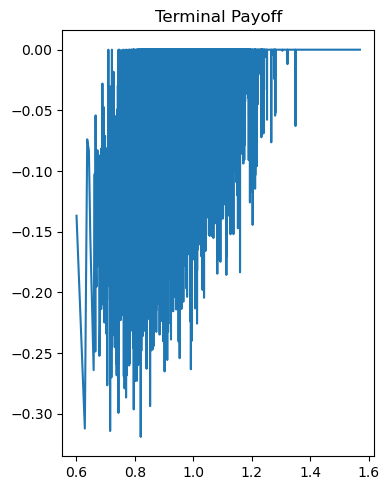

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from cdxbasics.dynaplot import figure
from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world

pcent = 0.2
put_strike = 1.0
lower_KO   = 1.-pcent
upper_KO   = 1.+pcent

def fwd_start( spots ):
    """ Short double KO put
    
        Parameters
        ----------
            spots : spots of the equity[None,nSteps]
            
        Returns
        -------
            Payoff [None]
    """
    l          = spots.shape[1]
    terminal   = np.maximum( put_strike * spots[:,l//2] - spots[:,-1], 0. )  # put
    return -terminal

config.world.samples = 20000
config.world.steps = 20
config.world.drift = 0.
config.world.black_scholes = True
config.world.payoff = fwd_start
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 5
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence = 10 # recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = config.world("samples")
config.trainer.train.epochs = 20000
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_recurrent = config.copy()

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)

fig = figure()
ax  = fig.add_subplot()
ax.set_title("Terminal Payoff")
spotsT = world.details.spot_all[:,-1]
payoff = world.data.market.payoff
ixs    = np.argsort(spotsT)
spotsT = spotsT[ixs]
payoff = payoff[ixs]
ax.plot( spotsT,payoff )
fig.render()
fig.close()

## Hedging a barrier with recurrence

Gym with 2204 trainable weights compiled and initialized. Took 2s
Agent is using 2202 weights: 2191 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/5052f273543a9e25f68f24fb56c63a40.pck'
Cache successful

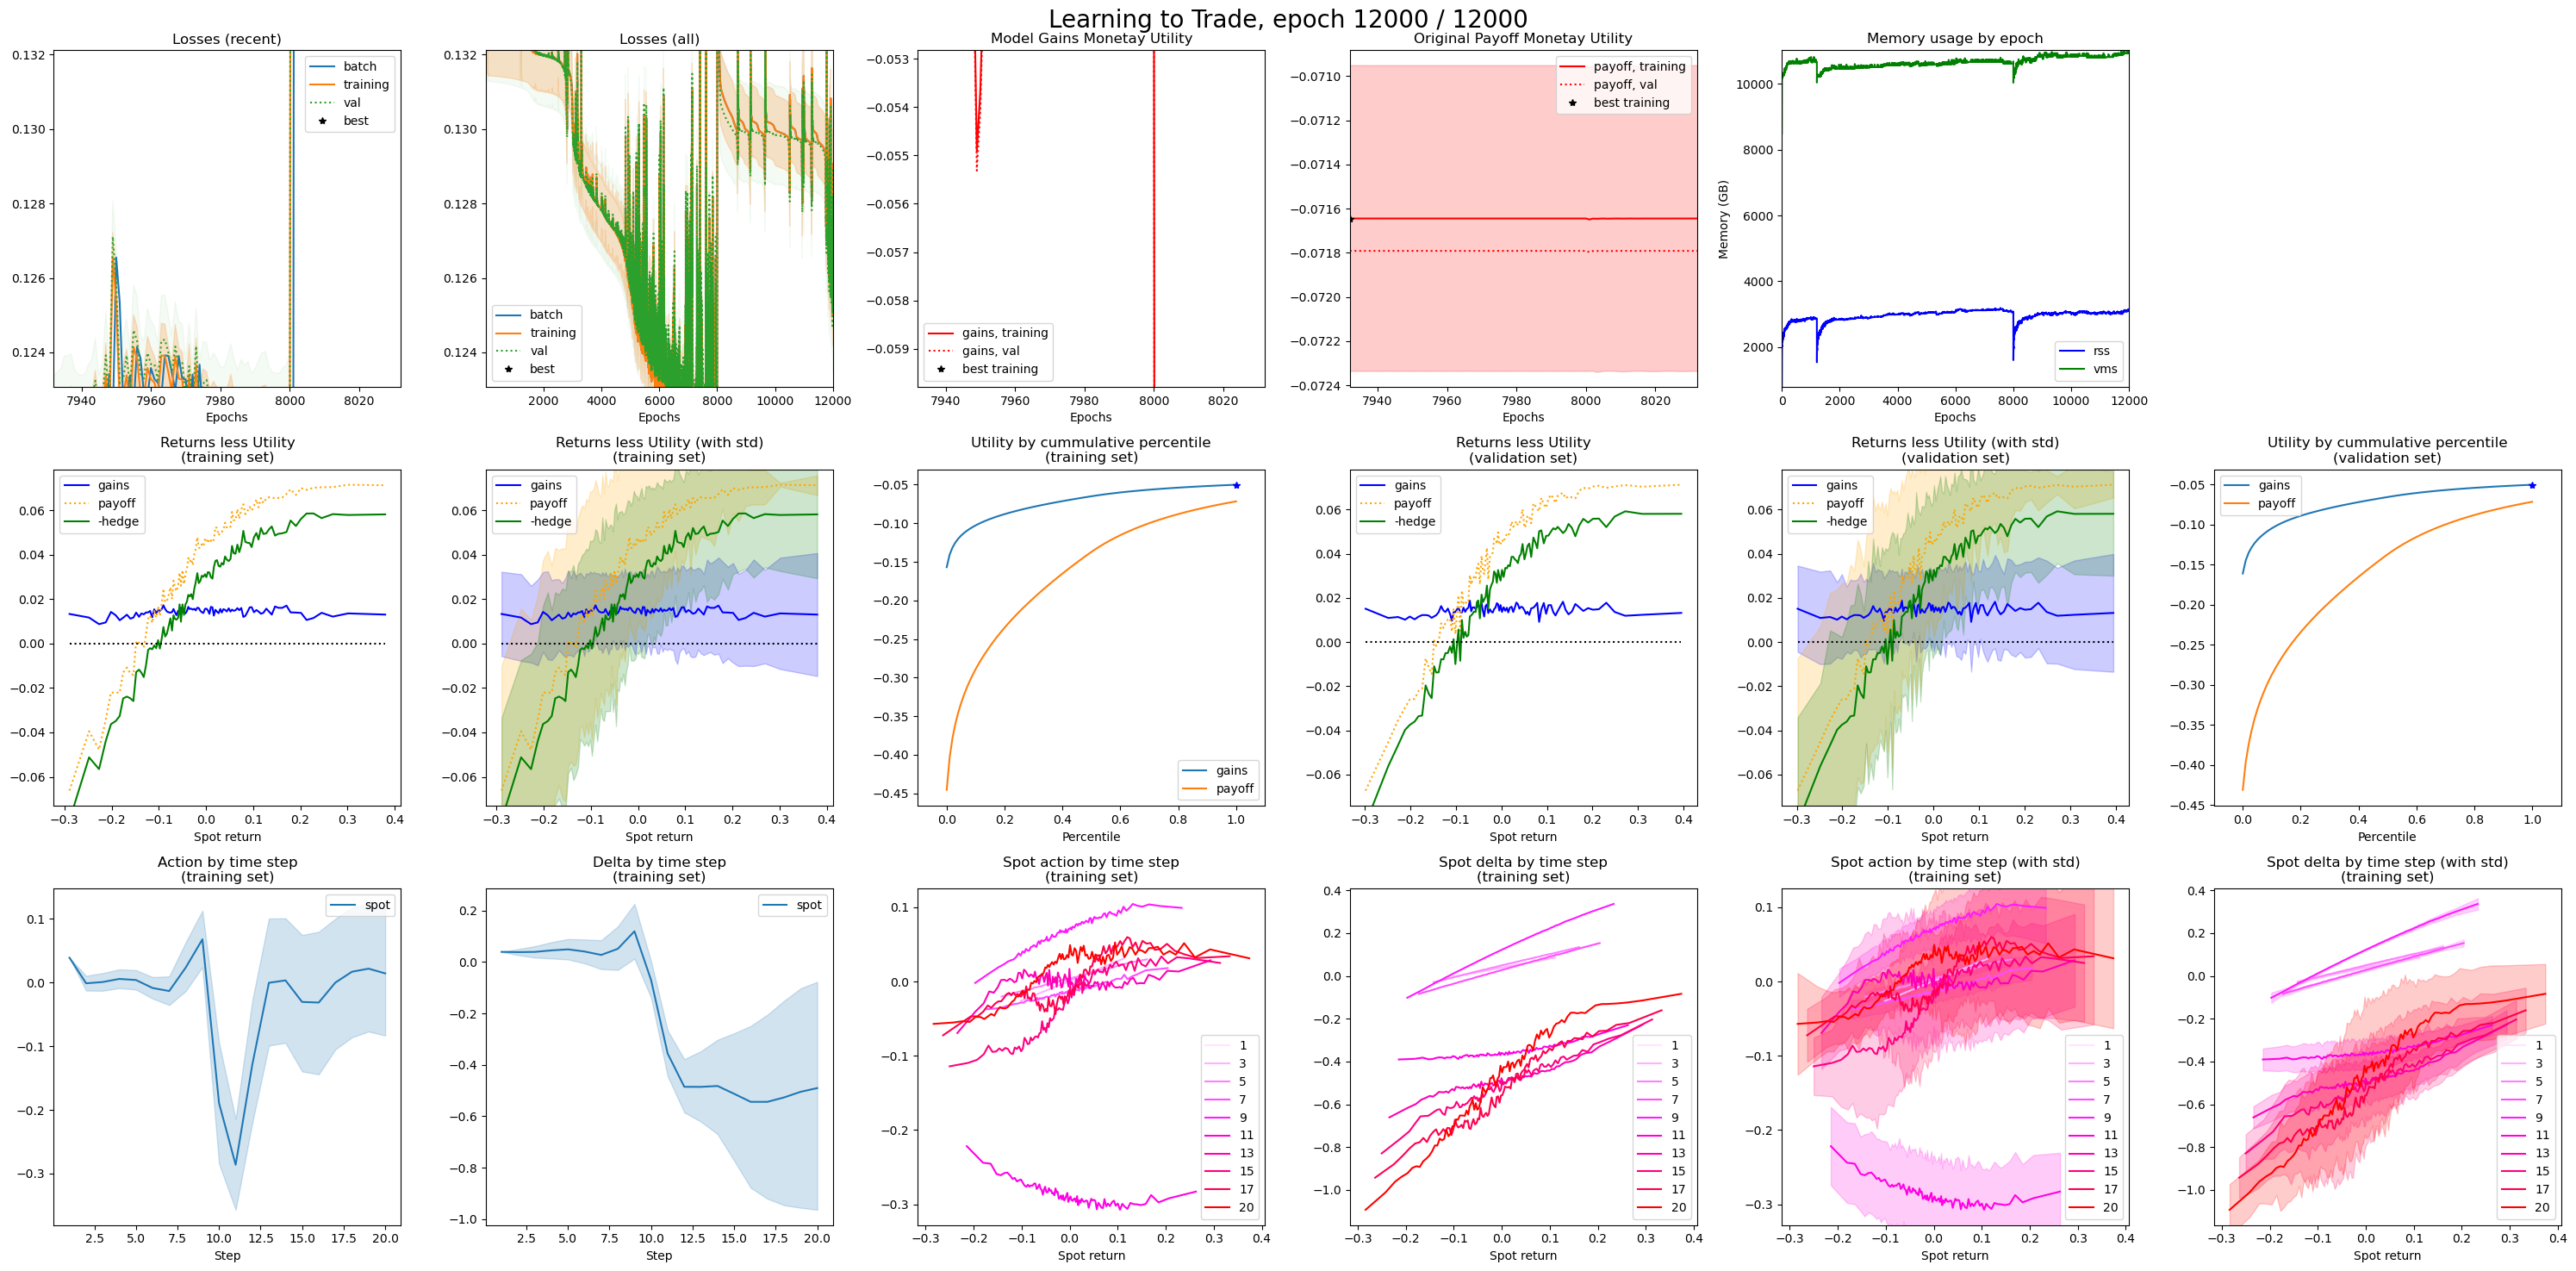

Training 12000/12000 epochs; 2204 weights; 20000 samples; 10000 validation samples batch size 20000 | initial loss 0.492651 (0.00437036), training 0.129074 (0.000925895), best 0.12174 (0.00437036), batch 0.127777, val 0.128993 (0.00130132). Best epoch 7932; last cached 12000. | memory used: rss 3093.25M, vms 10949.7M | time elapsed 38:34; time per epoch 0s; estimated time remaining 0s                          
 Status: Training complete.
 Weights set to best epoch: 7932
 State of training until epoch 12000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/5052f273543a9e25f68f24fb56c63a40.pck

Training terminated. Total time taken 27:35


In [3]:
# create training environment
display(Markdown("## Hedging a barrier with recurrence"))
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()

## Hedging a barrier without recurrence

Gym with 1784 trainable weights compiled and initialized. Took 0s
Agent is using 1782 weights: 1781 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cfed8730f5f751c12c5478b2ac9ab30d.pck'
Cache successfully loaded. Current epoch: 8000
Training monitor initialized. Took 0s



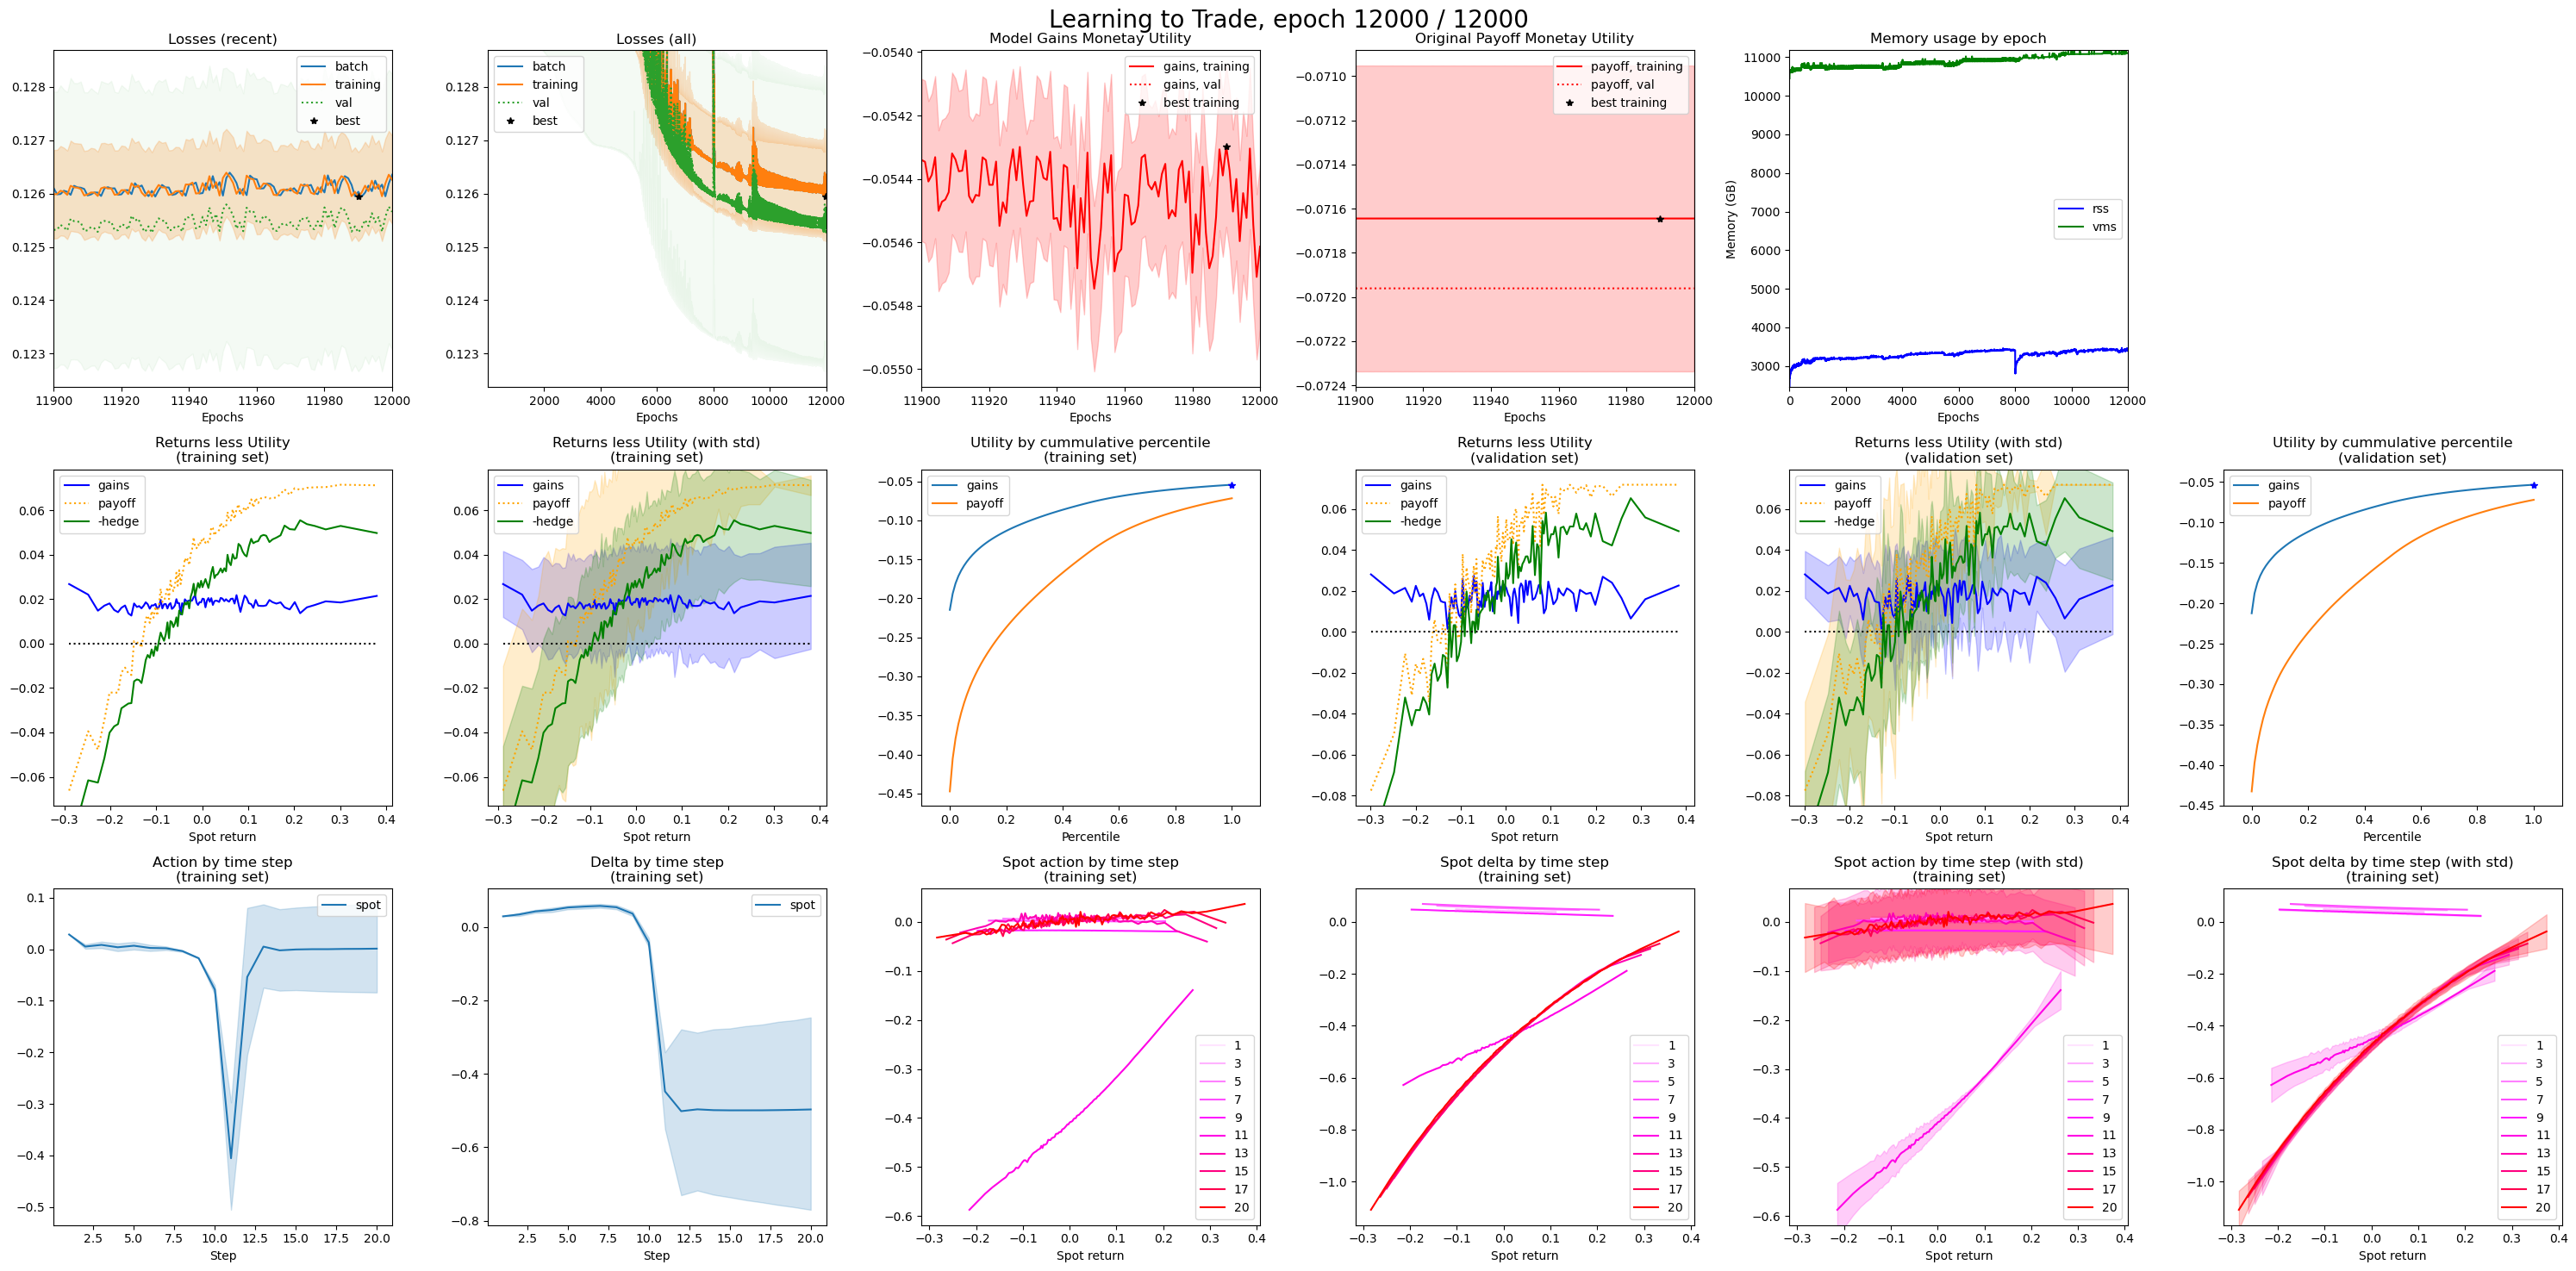

Training 12000/12000 epochs; 1784 weights; 20000 samples; 2000 validation samples batch size 20000 | initial loss 0.508281 (0.00453854), training 0.126258 (0.000827172), best 0.125941 (0.00453854), batch 0.126353, val 0.125657 (0.00258348). Best epoch 11990; last cached 12000. | memory used: rss 3409.95M, vms 11106.6M | time elapsed 38:23; time per epoch 0s; estimated time remaining 0s                          
 Status: Training complete.
 Weights set to best epoch: 11990
 State of training until epoch 12000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cfed8730f5f751c12c5478b2ac9ab30d.pck

Training terminated. Total time taken 24:20


In [4]:
config_recurrent.gym.agent.recurrence = 0 # recurrent nodes
config = config_recurrent

display(Markdown("## Hedging a barrier without recurrence"))

# create world
world2  = SimpleWorld_Spot_ATM( config.world )
val_world2  = world.clone(samples=world.nSamples//10)

# create training environment
gym2 = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym2, world=world2, val_world=val_world2, config=config.trainer )
config.done()

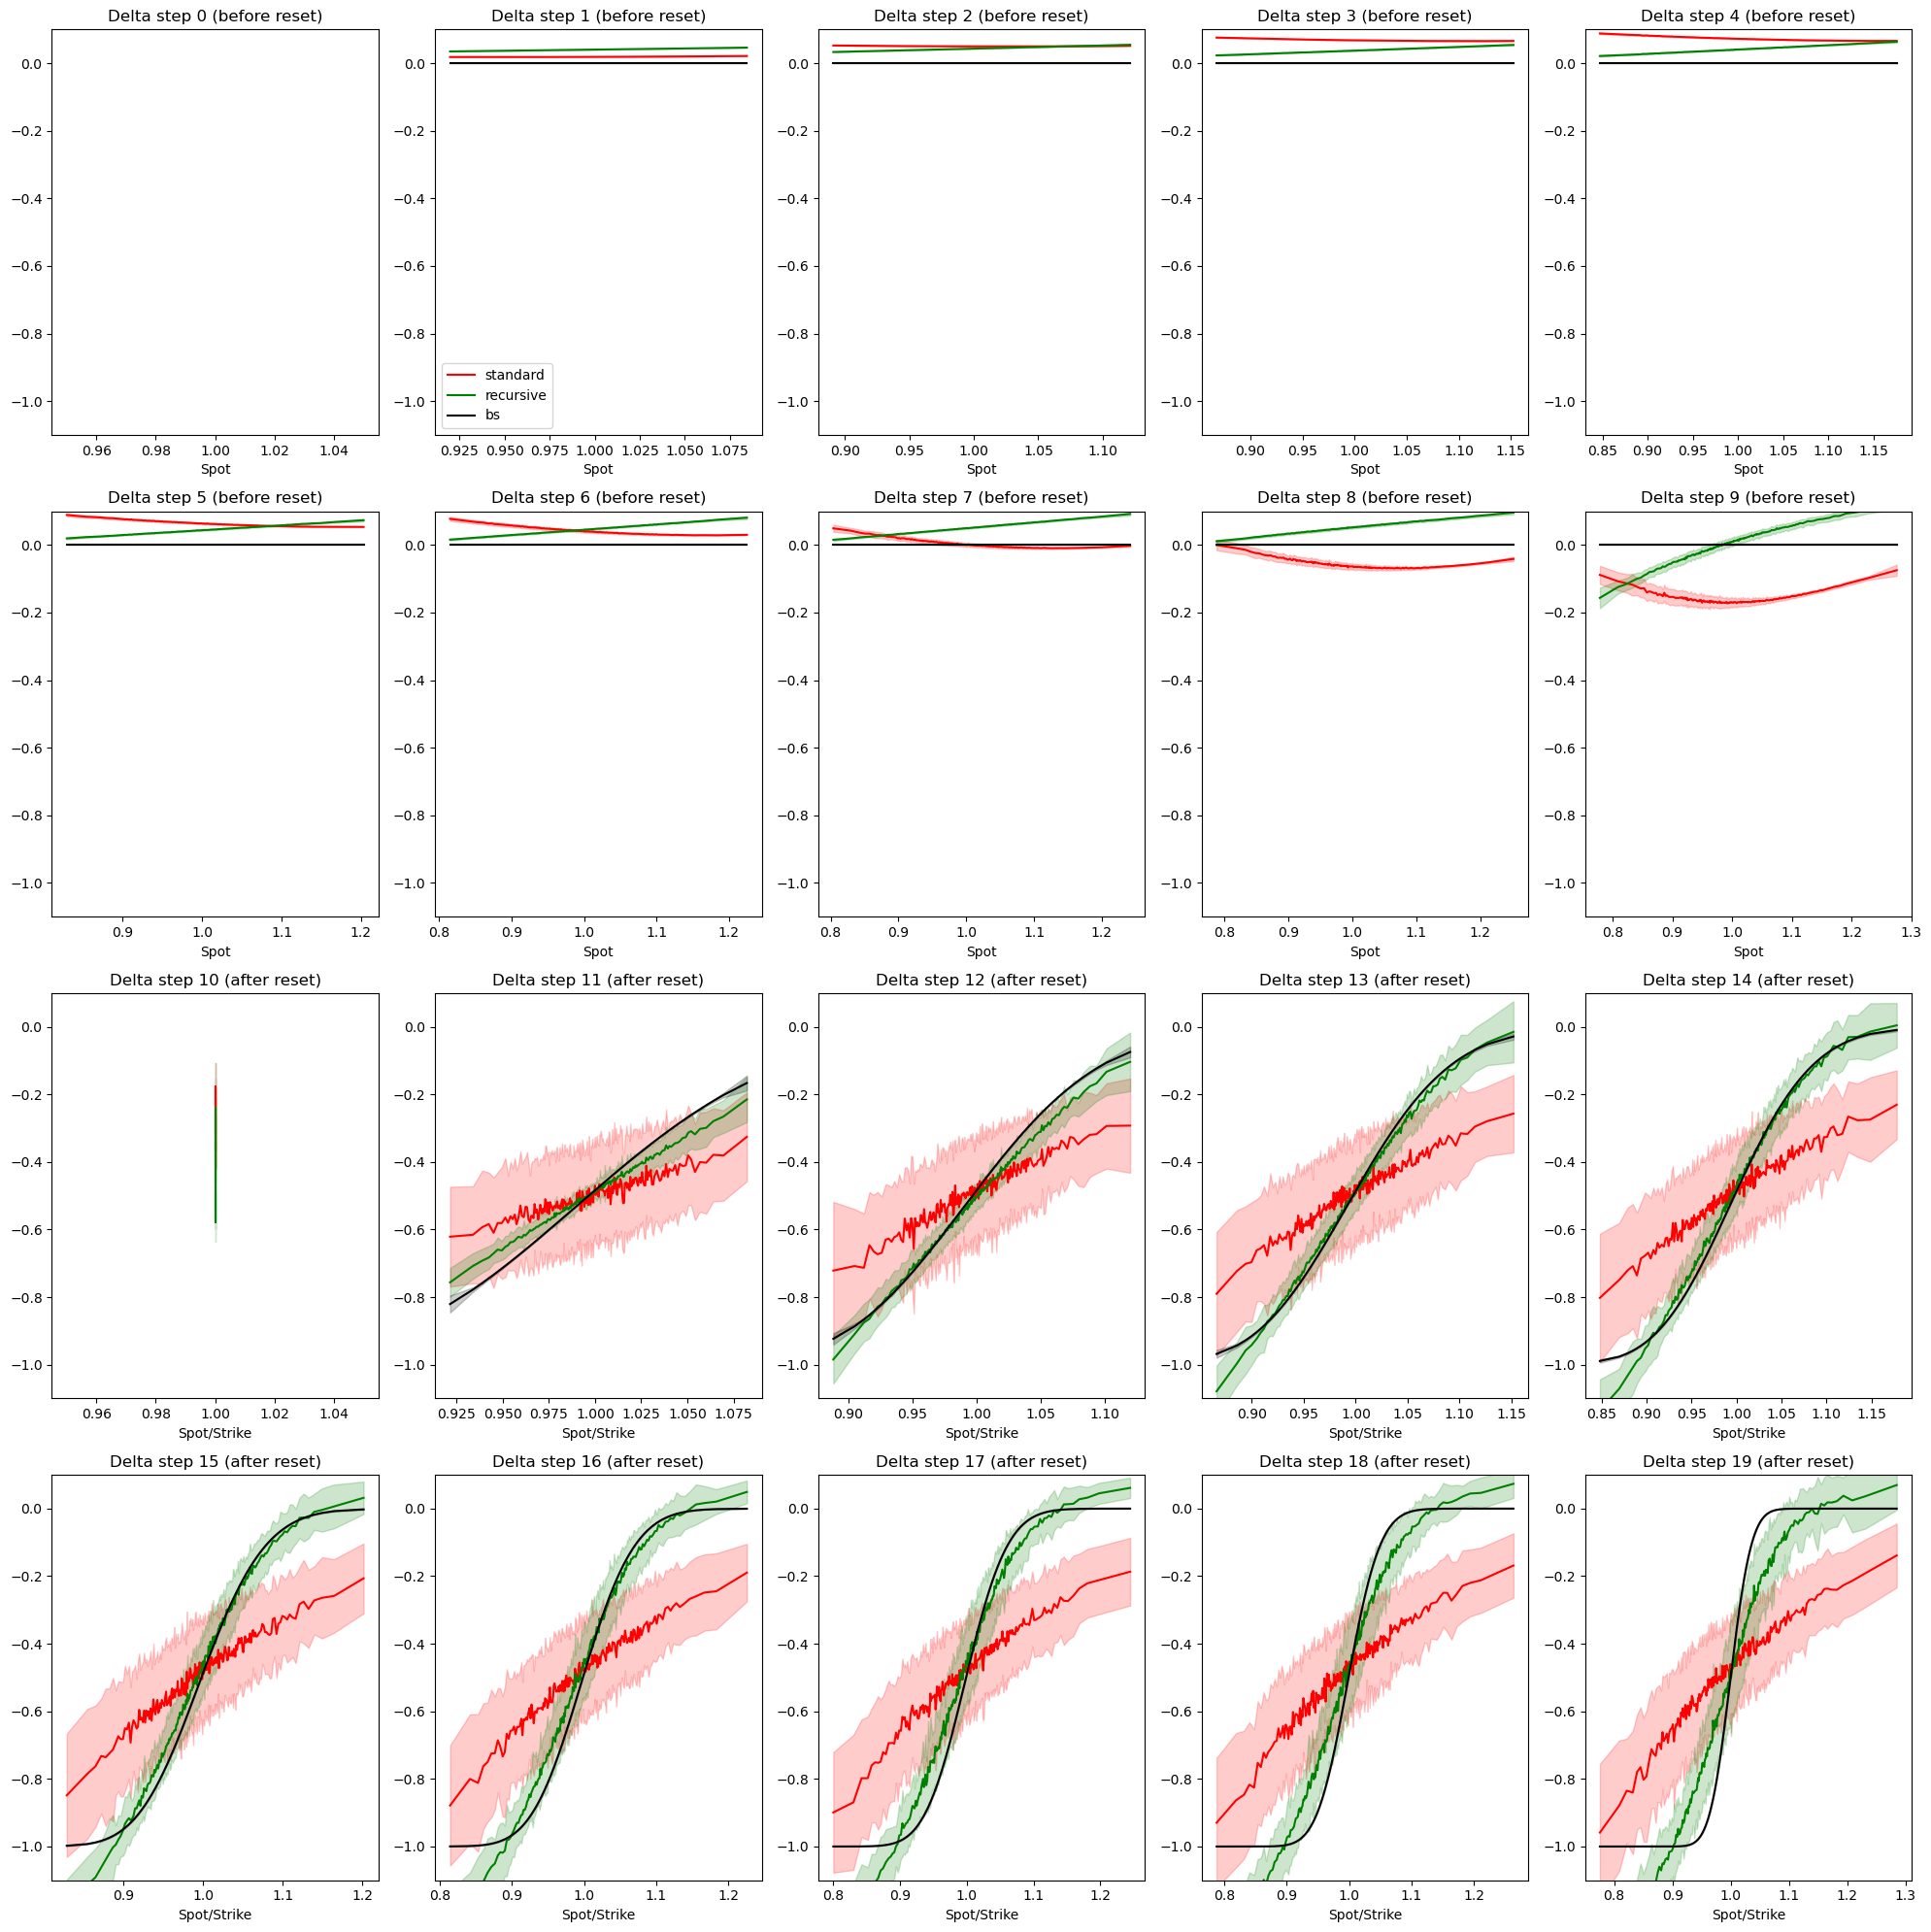

## Forward Starting Option Hedging

In [41]:
payoff = world.data.market.payoff

from deephedging.base import npCast, mean_bins
from cdxbasics.dynaplot import figure
from scipy.stats import norm
fig = figure()
display(Markdown("## Forward Starting Option Hedging"))

r1 = npCast( gym(world.tf_data) )
r2 = npCast( gym2(world2.tf_data) )
actions1   = r1['actions'][:,:,0]
actions2   = r2['actions'][:,:,0]
deltas1    = np.cumsum(actions1, axis=1)
deltas2    = np.cumsum(actions2, axis=1)
spots      = world.details.spot_all
payoff     = world.data.market.payoff
hedges     = world.data.market.hedges[:,:,0]
time_left  = world.data.features.per_step.time_left[0,:]
nSteps     = world.nSteps
iReset     = nSteps//2
nBinSteps = 7
ixs       = np.linspace(0,nSteps,nBinSteps,endpoint=True,dtype=np.int32)
vol       = config.world.get_raw("rvol", 0.2)

nBins     = 200

for j in range(nSteps):
    ax_delta  = fig.add_subplot()
    ax_delta.set_ylim(-1.1,0.1)

    # sort by spot at j, and compute BS refernece
    spot_t    = spots[:,j]
    delta1_t  = deltas1[:,j]
    delta2_t  = deltas2[:,j]
    hedges_t  = hedges[:,j]   # S(T)-S(t_j)
    res_t     = time_left[j] 

    # BS
    # note that the 'drift' in the simulator is the statistical drift, not the risk-neutral drift.
    if j<iReset:
        bsdelta_t      = delta1_t*0.
        ref_spot       = spot_t
        ax_delta.set_title("Delta step %ld (before reset)" % j)
        ax_delta.set_xlabel("Spot")
    else:
        strike        = spots[:,iReset]
        d1            = ( np.log(spot_t/strike) +  0.5 * vol * vol  * res_t ) / math.sqrt( res_t * vol * vol )
        d2            = d1 - vol * math.sqrt( res_t )
        N1            = norm.cdf(d1)
        N2            = norm.cdf(d2)
        bsprice_t     = spot_t * N1 - strike * N2      # call
        bsprice_t     = bsprice_t + strike - spot_t    # C=P+S-K
        bsdelta_t     = N1
        bsdelta_t     = bsdelta_t - 1.
        ref_spot      = spot_t/strike
        ax_delta.set_title("Delta step %ld (after reset)" % j)
        ax_delta.set_xlabel("Spot/Strike")

    ixs       = np.argsort(ref_spot)
    ref_spot  = ref_spot[ixs]
    delta1_t  = delta1_t[ixs]
    delta2_t  = delta2_t[ixs]
    bsdelta_t = bsdelta_t[ixs]
    
    x_mean          = mean_bins( ref_spot, bins=nBins, weights=world.sample_weights, return_std = False )
    d1_mean, d1_std = mean_bins( delta1_t, bins=nBins, weights=world.sample_weights, return_std = True )
    d2_mean, d2_std = mean_bins( delta2_t, bins=nBins, weights=world.sample_weights, return_std = True )
    bs_mean, bs_std = mean_bins( bsdelta_t, bins=nBins, weights=world.sample_weights, return_std = True )
    
    ax_delta.plot( x_mean, d2_mean, label="standard", color="red")
    ax_delta.plot( x_mean, d1_mean, label="recursive", color="green")
    ax_delta.plot( x_mean, bs_mean, label="bs", color="black")
    
    ax_delta.fill_between( x_mean, d2_mean-d2_std, d2_mean+d2_std, color="red", alpha=0.2 )
    ax_delta.fill_between( x_mean, d1_mean-d1_std, d1_mean+d1_std, color="green", alpha=0.2 )
    ax_delta.fill_between( x_mean, bs_mean-bs_std, bs_mean+bs_std, color="black", alpha=0.2 )

    if j==1:
        ax_delta.legend()
    
fig.close()
